In [1]:
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)
library(rwantshue)
library(RColorBrewer)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

In [3]:
%%R
physeq = import_biom("../../SeqData/ITS.otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)

In [4]:
%%R

#physeq = subset_samples(physeq, Sample!=)

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

#ps.merged = subset_samples(ps.merged,row.names(sample_data(ps.merged))!="S_2.5_14")
# Removing soil sample with large Onygenales taxon (Emmonsia) - soil saprotroph, but huge

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
sample_data(ps.merged)
# Cleaning up the sample data table
physeq = ps.merged

In [5]:
%%R
sample.data<-data.frame(sample_data(physeq)) %>%
    dplyr::group_by(Trtmt,Month) %>%
    dplyr::summarize(total=n())
sample.data
# Find out how many of each treatment-month combination we have... 
# Don't want to run it on anything with just one or two samples

Source: local data frame [14 x 3]
Groups: Trtmt

            Trtmt Month total
1           Blank    NA     1
2    Ferrihydrite   2.0     4
3    Ferrihydrite   2.5     9
4    Ferrihydrite   3.0     5
5  Heavy Fraction   2.5     3
6       Kaolinite   2.0     4
7       Kaolinite   2.5     8
8       Kaolinite   3.0     5
9          Quartz   2.0     4
10         Quartz   2.5     9
11         Quartz   3.0     5
12           Soil   2.0     5
13           Soil   2.5     6
14           Soil   3.0     5


In [6]:
%%R
# Creating a matrix with the different combinations of variables for day and amendment
variables = expand.grid(Trtmt = c("Kaolinite"),
                        Month = c(2, 2.5, 3))
#<-variables[c(1,2,4,5,6,7,8),]
variables

      Trtmt Month
1 Kaolinite   2.0
2 Kaolinite   2.5
3 Kaolinite   3.0


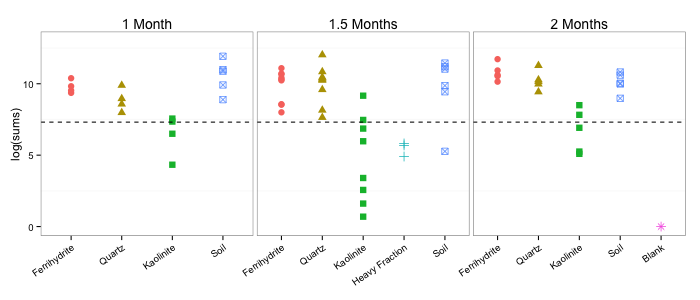

In [123]:
%%R -w 700 -h 300

sums = (sample_sums(physeq))
mdf = data.frame(sums)
mdf[,2] = row.names(mdf)
names = colnames(mdf)
mdf[,3] = substr(mdf[,2],1,1)
mdf[,4] = substr(mdf[,2],3,4)
colnames(mdf) = c(names[1],"Samples","Trtmt", "Month")
mdf$MonthName = ifelse(mdf$Month=='2_',"1 Month",(ifelse(mdf$Month=="2.", "1.5 Months","2 Months")))
mdf$Trtmt[mdf$Trtmt=="B"]="Blank"
mdf$Trtmt[mdf$Trtmt=="F"]="Ferrihydrite"
mdf$Trtmt[mdf$Trtmt=="Q"]="Quartz"
mdf$Trtmt[mdf$Trtmt=="H"]="Heavy Fraction"
mdf$Trtmt[mdf$Trtmt=="S"]="Soil"
mdf$Trtmt[mdf$Trtmt=="K"]="Kaolinite"
mdf$Trtmt = ordered(mdf$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil","Blank"))

p = ggplot(mdf, aes(x=Trtmt, y=log(sums), colour = Trtmt, shape = Trtmt))
p = p + facet_grid(~MonthName, scales="free_x")
p = p + geom_point(size = 3)
p = p + geom_hline(yintercept=log(1500),linetype='dashed',weight=2)
p = p + theme_bw()
p = p + theme(axis.text.x = element_text(angle=35, hjust=1),panel.grid.major= element_blank(), axis.title.x = element_blank(),strip.background = element_blank(),strip.text = element_text(size=14))
p = p + ylim(0,13)
p = p + guides(shape=FALSE,colour=FALSE)
ggsave(filename="CutoffITS.jpg", p, width=7, height=3)
p